In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
from datetime import date

In [32]:
MONTHS = ["Januaryyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy                                                                                      ", 
          "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
INPUT_CHARS = "".join(sorted(set("".join(MONTHS)))) + "1234567890 ,"
OUTPUT_CHARS = "0123456789-"
OUTPUT_NUMBER_TIMESTAMPS = len("2010-10-10")
BATCH_SIZE = 32
EMBED_SIZE = 32
NUMBER_OF_LSTM_NEURONS = 128
SOS_TOKEN = len(OUTPUT_CHARS) + 1

def str_to_ids(string, alphabet):
    return [alphabet.index(_) + 1 for _ in string]

def ids_to_str(ids, alphabet):
    return "".join([alphabet[_ - 1] for _ in ids])


ids_to_str(str_to_ids("April 22, 2019", INPUT_CHARS), INPUT_CHARS)
# ids_to_str(str_to_ids("2019-04-22", OUTPUT_CHARS), OUTPUT_CHARS)
# str_to_ids("2019-04-22", OUTPUT_CHARS)

'April 22, 2019'

In [33]:
def get_N_samples(num):
    __input, __output = [], []
    min_date_ord = date(1000, 1, 1).toordinal()
    max_date_ord = date(9999, 12, 31).toordinal()
    
    for _ in range(num):
        random_ord = np.random.randint(min_date_ord, max_date_ord)
        __input.append(str_to_ids(MONTHS[date.fromordinal(random_ord).month - 1] + " " + str(date.fromordinal(random_ord).day) + ", " + str(date.fromordinal(random_ord).year), INPUT_CHARS))
        __output.append(str_to_ids(date.fromordinal(random_ord).isoformat(), OUTPUT_CHARS))
    
    return __input, __output

spelling_dates, iso_dates = get_N_samples(2)
print(iso_dates)
print(spelling_dates)

[[3, 9, 4, 10, 11, 1, 10, 11, 3, 5], [2, 3, 1, 10, 11, 1, 9, 11, 1, 8]]
[[9, 13, 21, 24, 13, 18, 11, 13, 22, 1, 29, 31, 39, 1, 29, 35, 30, 36], [2, 25, 14, 25, 23, 24, 1, 34, 39, 1, 28, 29, 37, 36]]


In [34]:
def get_dataset(num_samples):
    spelling_dates, iso_dates = get_N_samples(num_samples)
    return tf.data.Dataset.from_tensor_slices((tf.ragged.constant(spelling_dates), tf.constant(iso_dates))).batch(32)

train_ds = get_dataset(BATCH_SIZE * 400)
valid_ds = get_dataset(BATCH_SIZE * 40)

ds = get_dataset(10)
for __X, __y in ds.take(2):
    print(__X, __y)

<tf.RaggedTensor [[9, 13, 21, 24, 13, 18, 11, 13, 22, 1, 31, 39, 1, 30, 31, 34, 34], [4, 13, 11, 22, 25, 10, 22, 27, 1, 35, 39, 1, 30, 32, 33, 28], [5, 25, 17, 27, 1, 29, 36, 39, 1, 32, 37, 31, 30], [7, 20, 26, 13, 18, 11, 13, 22, 1, 29, 35, 39, 1, 32, 28, 32, 28], [6, 10, 27, 1, 29, 36, 39, 1, 29, 31, 33, 35], [9, 13, 21, 24, 13, 18, 11, 13, 22, 1, 28, 32, 39, 1, 35, 37, 28, 34], [6, 10, 27, 1, 28, 39, 1, 30, 33, 29, 37], [6, 10, 27, 1, 28, 30, 39, 1, 32, 36, 32, 31], [7, 20, 26, 13, 18, 11, 13, 22, 1, 28, 29, 39, 1, 33, 29, 29, 35], [5, 10, 19, 25, 10, 22, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [38]:
def get_dataset_2(num_samples):
    spelling_dates, iso_dates = get_N_samples(num_samples)
    return tf.ragged.constant(spelling_dates), tf.constant(iso_dates)

train_ds_x, train_ds_y = get_dataset_2(90)
valid_ds_x, valid_ds_y = get_dataset_2(2)

train_ds_x.to_tensor()

<tf.Tensor: shape=(90, 183), dtype=int32, numpy=
array([[ 8, 12, 24, ...,  0,  0,  0],
       [ 8, 12, 24, ...,  0,  0,  0],
       [ 5, 25, 17, ...,  0,  0,  0],
       ...,
       [ 9, 13, 21, ...,  0,  0,  0],
       [ 9, 13, 21, ...,  0,  0,  0],
       [ 2, 21, 22, ...,  0,  0,  0]])>

In [7]:
idx = 0
for x_batch, y_batch in ds.shuffle(10).take(2):
    idx += 1
    print(idx, ")")
    for __X, __y in zip(x_batch, y_batch):
        print(ids_to_str(__X, INPUT_CHARS), "->", ids_to_str(__y, OUTPUT_CHARS))

1 )
August 4, 9544 -> 9544-08-04
May 14, 7329 -> 7329-05-14
December 12, 9152 -> 9152-12-12
December 2, 7772 -> 7772-12-02
December 3, 8613 -> 8613-12-03
August 9, 6559 -> 6559-08-09
December 12, 3564 -> 3564-12-12
January 1, 1767 -> 1767-01-01
September 23, 9944 -> 9944-09-23
February 10, 3668 -> 3668-02-10


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 128)               68803     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 128)           0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 10, 12)            133132    
Total params: 201,935
Trainable params: 201,935
Non-trainable params: 0
_________________________________________________________________
None


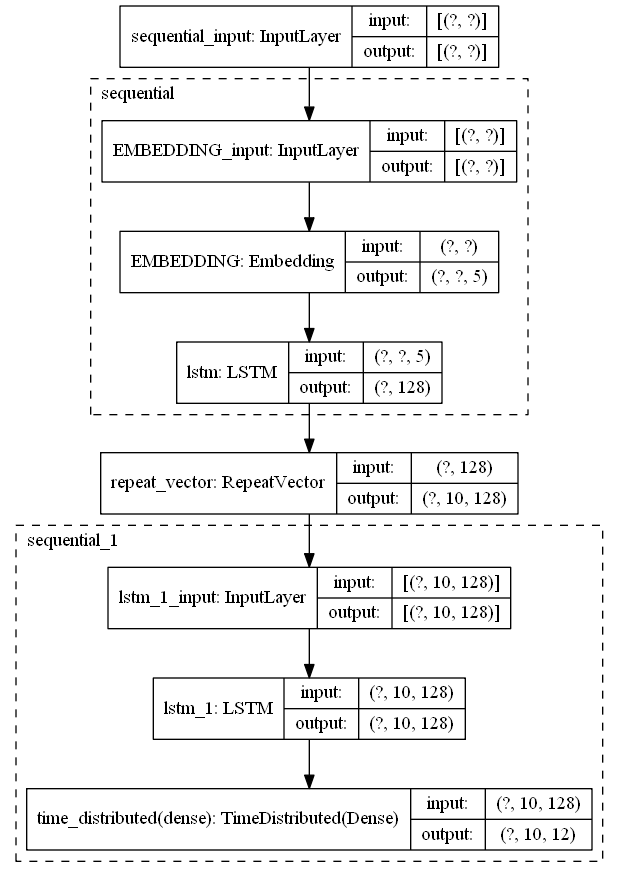

In [8]:
encoder = keras.models.Sequential([
#     keras.layers.InputLayer(batch_input_shape = [BATCH_SIZE, None], ragged=True, name="INPUT"),
#     keras.layers.Embedding(input_dim = len(INPUT_CHARS) + 1, output_dim = EMBED_SIZE, name="EMBEDDING"),
    keras.layers.Embedding(input_dim = len(INPUT_CHARS) + 1, output_dim = EMBED_SIZE, input_shape = [None], name="EMBEDDING"),
    keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS),
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_sequences = True, input_shape=[OUTPUT_NUMBER_TIMESTAMPS, NUMBER_OF_LSTM_NEURONS]),
    keras.layers.TimeDistributed(keras.layers.Dense(len(OUTPUT_CHARS)+1, activation="softmax")),
#     keras.layers.Dense(len(OUTPUT_CHARS)),
])

model = keras.models.Sequential([
    encoder,
#     keras.layers.RepeatVector(train_ds_y.shape[1]),
    keras.layers.RepeatVector(OUTPUT_NUMBER_TIMESTAMPS),
    decoder
])

print(model.summary())
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)



In [9]:
model.compile(loss=["sparse_categorical_crossentropy"], optimizer = "adam", metrics=["accuracy"])
history = model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/2


C:\Users\ikuchin\AppData\Local\Continuum\miniconda3\envs\tf22\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


400/400 [==============================] - 9s 22ms/step - loss: 1.6828 - accuracy: 0.3936 - val_loss: 1.2187 - val_accuracy: 0.5473
Epoch 2/2
400/400 [==============================] - 8s 20ms/step - loss: 0.9980 - accuracy: 0.6364 - val_loss: 0.7672 - val_accuracy: 0.7292


In [10]:
test_batch = [
str_to_ids("April 10, 1980", INPUT_CHARS),    
]
pred = model.predict_classes(test_batch)

ids_to_str(pred[0], OUTPUT_CHARS)



Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


'9090-04-10'

#### Option 2: decoder with shifted input

In [39]:
def shifted_timeseries(series):
    result = np.zeros(series.shape, dtype=np.int32) + SOS_TOKEN
    result[:, 1:] = series[:, :-1]
    return tf.constant(result)

X_train, Y_train = get_dataset_2(10000)
X_valid, Y_valid = get_dataset_2(2000)
X_test, Y_test = get_dataset_2(10)

X_train_decoder = shifted_timeseries(Y_train)
X_valid_decoder = shifted_timeseries(Y_valid)
X_test_decoder = shifted_timeseries(Y_test)



In [92]:
encoder_input = keras.layers.Input(shape=[None])
encoder_embed = keras.layers.Embedding(input_dim = len(INPUT_CHARS) + 1, output_dim = EMBED_SIZE)(encoder_input)
encoder_lstm_output, encoder_state_h, encoder_state_c  = keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_state=True)(encoder_embed)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None])
decoder_embed = keras.layers.Embedding(input_dim = len(OUTPUT_CHARS) + 2, output_dim = EMBED_SIZE)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_sequences=True)(decoder_embed, initial_state=encoder_state)
decoder_output = keras.layers.TimeDistributed(keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax"))(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input], outputs=[decoder_output])
model.compile(loss=["sparse_categorical_crossentropy"], optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, None, 5)      195         input_26[0][0]                   
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, None, 5)      65          input_27[0][0]                   
____________________________________________________________________________________________

In [95]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=20, validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/20
313/313 [==============================] - 7s 21ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 2/20
313/313 [==============================] - 9s 29ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 1.0000
Epoch 3/20
313/313 [==============================] - 9s 28ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/20
313/313 [==============================] - 8s 26ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/20
313/313 [==============================] - 10s 31ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/20
313/313 [==============================] - 11s 34ms/step - loss: 8.8624e-04 - accuracy: 1.0000 - val_loss: 9.2968e-04 - val_accuracy: 1.0000
Epoch 7/20
313/313 [==============================] - 11s 34ms/step - loss: 7.3159e-04 - accuracy: 1.0000 - val_loss: 7.7976e-04 - v

In [88]:
print(ids_to_str(X_train.to_tensor()[0].numpy(), INPUT_CHARS))
print(ids_to_str(X_train_decoder[0].numpy()[1:], OUTPUT_CHARS))
print(ids_to_str(Y_train[0].numpy(), OUTPUT_CHARS))


April 18, 4949,,,,
4949-04-1
4949-04-18


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


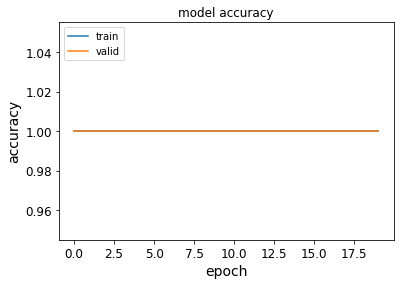

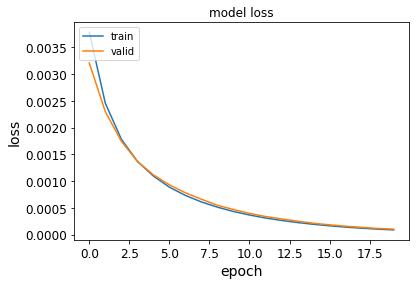

In [96]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [173]:
test_input = tf.constant([X_test[0].numpy()])
# test_decoder_input = tf.constant([X_test_decoder[0].numpy()])
test_decoder_input = tf.constant([[12, 3, 2, 7, 1, 11, 2, 2, 11, 2]])
pred = model.predict([test_input, test_decoder_input])
pred_classes = tf.argmax(pred, axis=-1)
# print(pred)
print(pred_classes)
print(ids_to_str(pred_classes.numpy()[0], OUTPUT_CHARS))

tf.Tensor([[ 3  2  7  1 11  2  2 11  2  2]], shape=(1, 10), dtype=int64)
2160-11-11


In [143]:
ids_to_str(Y_test[0].numpy(), OUTPUT_CHARS)

'2160-11-11'

In [148]:
X_test_decoder[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([12,  3,  2,  7,  1, 11,  2,  2, 11,  2])>

#### Option 3: reworked option 2 with BasicEncoder

In [2]:
import tensorflow_addons as tfa

In [115]:
encoder_input = keras.layers.Input([None])
encoder_embedding = keras.layers.Embedding(input_dim = len(INPUT_CHARS) + 1, output_dim = EMBED_SIZE)(encoder_input)
encoder_lstm, encoder_state_h, encoder_state_c = keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

# sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

decoder_input = keras.layers.Input([None])
decoder_embedding_layer = keras.layers.Embedding(input_dim = len(OUTPUT_CHARS) + 2, output_dim = EMBED_SIZE)
decoder_embedding = decoder_embedding_layer(decoder_input)

decoder_cells = keras.layers.LSTMCell(NUMBER_OF_LSTM_NEURONS)
decoder_sampler = tfa.seq2seq.TrainingSampler()
dense_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
decoder = tfa.seq2seq.BasicDecoder(cell = decoder_cells, sampler = decoder_sampler, output_layer = dense_output)
decoder_output, decoder_state, decoder_seq_len = decoder(decoder_embedding, initial_state = encoder_state, training=True)
Y_proba = keras.layers.Activation("softmax")(decoder_output.rnn_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input], outputs = [Y_proba])
model.compile(loss = ["sparse_categorical_crossentropy"], optimizer="adam", metrics=["accuracy"])

In [116]:
history = model.fit([X_train, X_train_decoder], Y_train, epochs=20, validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/20


C:\Users\ikuchin\AppData\Local\Continuum\miniconda3\envs\tf22\lib\site-packages\tensorflow\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


313/313 [==============================] - 10s 31ms/step - loss: 1.7107 - accuracy: 0.3656 - val_loss: 1.3883 - val_accuracy: 0.4613
Epoch 2/20
313/313 [==============================] - 9s 29ms/step - loss: 1.2720 - accuracy: 0.5121 - val_loss: 1.1025 - val_accuracy: 0.5818
Epoch 3/20
313/313 [==============================] - 9s 29ms/step - loss: 0.9181 - accuracy: 0.6575 - val_loss: 0.7415 - val_accuracy: 0.7359
Epoch 4/20
313/313 [==============================] - 9s 30ms/step - loss: 0.5473 - accuracy: 0.8169 - val_loss: 0.3909 - val_accuracy: 0.8831
Epoch 5/20
313/313 [==============================] - 9s 30ms/step - loss: 0.2844 - accuracy: 0.9242 - val_loss: 0.1964 - val_accuracy: 0.9539
Epoch 6/20
313/313 [==============================] - 9s 29ms/step - loss: 0.1444 - accuracy: 0.9735 - val_loss: 0.0961 - val_accuracy: 0.9894
Epoch 7/20
313/313 [==============================] - 9s 30ms/step - loss: 0.0768 - accuracy: 0.9914 - val_loss: 0.0599 - val_accuracy: 0.9936
Epoch 8/2

In [117]:
def predict_output(arr):
    result = []
    for arr_item in arr:
        item_encoded = tf.constant([str_to_ids(arr_item, INPUT_CHARS)])
        decoder_input = tf.fill(dims=(1,1), value=SOS_TOKEN)
        for idx in range(OUTPUT_NUMBER_TIMESTAMPS):
            y_proba = model.predict([item_encoded, decoder_input])
            y_proba_argmax = tf.argmax(y_proba, axis=-1)
            y_proba_argmax = tf.cast(y_proba_argmax, dtype=tf.int32)
            np.append(decoder_input, y_proba_argmax)
#             print(decoder_input, y_proba_argmax)
            decoder_input = tf.concat([decoder_input, y_proba_argmax[:, -1:]], axis=-1)
        
        result.append(ids_to_str(decoder_input[0, 1:], OUTPUT_CHARS))
    return result

print(predict_output(["January 10, 2020", "February 20, 2022"]))

['2020-01-10', '2022-02-20']


In [118]:
inference_sampler = tfa.seq2seq.GreedyEmbeddingSampler(embedding_fn=decoder_embedding_layer)
inference_decoder = tfa.seq2seq.BasicDecoder(cell=decoder_cells, sampler=inference_sampler, output_layer = dense_output, maximum_iterations=OUTPUT_NUMBER_TIMESTAMPS)
batch_size = tf.shape(encoder_input)[:1]
inference_decoder_X = tf.fill(dims=batch_size, value=SOS_TOKEN)
inference_decoder_outputs, inference_decoder_state, inferenece_decoder_seq_len = inference_decoder(
    inference_decoder_X,
    initial_state = encoder_state,
    start_tokens = inference_decoder_X,
    end_token = 0,
    training=False
)
model_inference = keras.models.Model(inputs=[encoder_input], outputs=[inference_decoder_outputs.sample_id])

In [119]:
def fast_predict_output(arr):
    result = []
    for arr_item in arr:
        item_encoded = tf.constant([str_to_ids(arr_item, INPUT_CHARS)])
        pred_Y = model_inference.predict([item_encoded])
        result.append(ids_to_str(pred_Y[0], OUTPUT_CHARS))
        
    return result


print(fast_predict_output(["January 10, 2020", "February 20, 2022"]))

['2020-01-10', '2022-02-20']


#### Option 4: Scheduler sampler implementation

In [53]:
encoder_input = keras.layers.Input([None])
encoder_embedding = keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1, output_dim = EMBED_SIZE)(encoder_input)
encoder_output, encoder_state_c, encoder_state_h = keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_c, encoder_state_h]

decoder_input = keras.layers.Input([None])
decoder_embedding_layer = keras.layers.Embedding(input_dim = len(OUTPUT_CHARS) + 2, output_dim = EMBED_SIZE)
decoder_embedding = decoder_embedding_layer(decoder_input)
decoder_cell = keras.layers.LSTMCell(NUMBER_OF_LSTM_NEURONS)
decoder_output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)

decoder_sampler = tfa.seq2seq.ScheduledEmbeddingTrainingSampler(sampling_probability = 0., embedding_fn=decoder_embedding_layer)
decoder_sampler.sampling_probability = tf.Variable(0.)

decoder = tfa.seq2seq.BasicDecoder(cell = decoder_cell, sampler = decoder_sampler, output_layer = decoder_output_layer)

decoder_output, decoder_state, decoder_seq_len = decoder(decoder_embedding, initial_state = encoder_state, training=True)
Y_proba = keras.layers.Activation("softmax")(decoder_output.rnn_output)

model = keras.models.Model(inputs = [encoder_input, decoder_input], outputs = [Y_proba])


model.compile(loss=["sparse_categorical_crossentropy"], optimizer="adam", metrics=["accuracy"])


In [54]:
n_epochs = 20

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        sampling_probability = max(0.0, (epoch - 10) / (n_epochs))
        decoder_sampler.sampling_probability.assign(sampling_probability)
        
        print("epoch {} sampling prob {}:".format(epoch, sampling_probability))

history = model.fit([X_train.to_tensor(), X_train_decoder], Y_train, epochs=n_epochs, validation_data=([X_valid.to_tensor(), X_valid_decoder], Y_valid), callbacks=[CustomCallback()])

epoch 0 sampling prob 0.0:
Epoch 1/20
313/313 [==============================] - 75s 239ms/step - loss: 1.6947 - accuracy: 0.3518 - val_loss: 1.4965 - val_accuracy: 0.3857
epoch 1 sampling prob 0.0:
Epoch 2/20
313/313 [==============================] - 74s 237ms/step - loss: 1.4908 - accuracy: 0.3878 - val_loss: 1.4861 - val_accuracy: 0.3859
epoch 2 sampling prob 0.0:
Epoch 3/20
313/313 [==============================] - 71s 226ms/step - loss: 1.4823 - accuracy: 0.3873 - val_loss: 1.4811 - val_accuracy: 0.3912
epoch 3 sampling prob 0.0:
Epoch 4/20
313/313 [==============================] - 69s 222ms/step - loss: 1.4811 - accuracy: 0.3890 - val_loss: 1.4787 - val_accuracy: 0.3908
epoch 4 sampling prob 0.0:
Epoch 5/20
313/313 [==============================] - 71s 227ms/step - loss: 1.4750 - accuracy: 0.3906 - val_loss: 1.4766 - val_accuracy: 0.3894
epoch 5 sampling prob 0.0:
Epoch 6/20
313/313 [==============================] - 68s 219ms/step - loss: 1.4724 - accuracy: 0.3962 - val_loss

In [82]:
model.evaluate([X_valid, X_valid_decoder], Y_valid)

63/63 [==============================] - 0s 8ms/step - loss: 0.0082 - accuracy: 0.9980


[0.008213719353079796, 0.9980499744415283]

In [119]:
softmax_temperature = tf.Variable(1.)

inference_sampler = tfa.seq2seq.SampleEmbeddingSampler(embedding_fn = decoder_embedding_layer, softmax_temperature = softmax_temperature)
inference_decoder = tfa.seq2seq.BasicDecoder(cell = decoder_cell, sampler = inference_sampler, output_layer = decoder_output_layer, maximum_iterations = OUTPUT_NUMBER_TIMESTAMPS)

batch_size = tf.shape(encoder_input)[1:]
print(batch_size)
start_tokens = tf.fill(dims = batch_size, value=SOS_TOKEN)

inference_decoder_outputs, inference_decoder_state, inferenece_decoder_seq_len = inference_decoder(
    start_tokens,
    initial_state = encoder_state,
    start_tokens = start_tokens,
    end_token = 0,
    training = False
)

inference_model = keras.models.Model(inputs=[encoder_input], outputs=[inference_decoder_outputs.sample_id])

Tensor("strided_slice_15:0", shape=(1,), dtype=int32)


In [166]:
def temperature_inference(inputs, temp=1.0):
    result = []
    softmax_temperature.assign(temp)
    for item in inputs:
        encoding = tf.constant([str_to_ids(item, INPUT_CHARS)])
        Y_pred = inference_model.predict([encoding])
        print(Y_pred)
        result.append(ids_to_str(Y_pred[0], OUTPUT_CHARS))
        
    return result

print(temperature_inference(["February 28, 2009"], 1.))
print(temperature_inference(["February 28, 2009"], 5.))

[[ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]
 [ 3  1  1 10 11  1  3 11  3  9]]
['2009-02-28']
[[ 3  5  1 10 11  2  3 11  9  4]
 [ 3  1  4  6 11  1  9  3  1  2]
 [ 9  1  1 10 11  1  3 11  1  9]
 [ 3  1  6  3  2  1  2 11  3  3]
 [ 3  1  1 10 11  1  3  3  1  3]
 [ 3  1  6  2 10  3  3  9  1  3]
 [ 1  1  1 10 11  1  3 11  3  0]
 [ 3  5 10  5 11  1  3 11  3  7]
 [ 9  0  1  4  5  2  0 11  0  9]
 [ 3  3  1  1 11  1 11  3  3  9]
 [ 4  6  3  5 11  4  3  3  3  9]
 [ 3  1  1 10  7 10  3 11  3  9]
 [ 4 11  1  3  1  2  3 11 1

#### Option 5: Attention mechanism

In [55]:
class DateTranslation(keras.models.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder_emb_layer = keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1, output_dim=EMBED_SIZE)
        self.encoder_lstm_layer = keras.layers.LSTM(NUMBER_OF_LSTM_NEURONS, return_state=True, return_sequences=True)
        
        self.decoder_emb_layer = keras.layers.Embedding(input_dim=len(OUTPUT_CHARS) + 2, output_dim=EMBED_SIZE)
        self.decoder_lstm_cells = keras.layers.LSTMCell(NUMBER_OF_LSTM_NEURONS)
        
        self.attention = tfa.seq2seq.LuongAttention(NUMBER_OF_LSTM_NEURONS)
        self.decoder_cell = tfa.seq2seq.AttentionWrapper(
            self.decoder_lstm_cells,
            attention_mechanism = self.attention
        )
        self.output_layer = keras.layers.Dense(len(OUTPUT_CHARS) + 1)
        self.training_decoder = tfa.seq2seq.BasicDecoder(
            self.decoder_cell, 
            sampler = tfa.seq2seq.TrainingSampler(),
            output_layer = self.output_layer
        )
        self.inference_decoder = tfa.seq2seq.BasicDecoder(
            self.decoder_cell,
            sampler = tfa.seq2seq.GreedyEmbeddingSampler(embedding_fn = self.decoder_emb_layer),
            output_layer = self.output_layer,
            maximum_iterations = OUTPUT_NUMBER_TIMESTAMPS,
        )
        
    def call(self, inputs, training = None):
        encoder_input, decoder_input = inputs
        encoder_emb = self.encoder_emb_layer(encoder_input)
        encoder_output, encoder_state_h, encoder_state_c = self.encoder_lstm_layer(encoder_emb, training=training)
        encoder_state = [encoder_state_h, encoder_state_c]

        self.attention(encoder_output, setup_memory=True) # --- try to move it to __init__

        # --- decoder part
        decoder_emb = self.decoder_emb_layer(decoder_input)
        decoder_initial_state = self.decoder_cell.get_initial_state(decoder_emb)
        decoder_initial_state = decoder_initial_state.clone(cell_state = encoder_state)

        if training:
            decoder_output, decoder_state, decoder_seq_length = self.training_decoder(
                decoder_emb, 
                initial_state = decoder_initial_state,
                training = True
            )
        else:
            start_tokens = tf.zeros_like(decoder_input)[:,0] + SOS_TOKEN
            decoder_output, decoder_state, decoder_seq_len = self.inference_decoder(
                decoder_emb, 
                initial_state = decoder_initial_state, 
                start_tokens = start_tokens,
                end_token = 0,
                training = False
            )
        
        
        return tf.nn.softmax(decoder_output.rnn_output)
    
model = DateTranslation()

In [56]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit([X_train.to_tensor(), X_train_decoder], Y_train, epochs=20, validation_data=([X_valid.to_tensor(), X_valid_decoder], Y_valid))

Epoch 1/20
313/313 [==============================] - 97s 311ms/step - loss: 2.1569 - accuracy: 0.2503 - val_loss: 2.0768 - val_accuracy: 0.2697
Epoch 2/20
313/313 [==============================] - 100s 321ms/step - loss: 1.4288 - accuracy: 0.5215 - val_loss: 1.1819 - val_accuracy: 0.6000
Epoch 3/20
313/313 [==============================] - 90s 287ms/step - loss: 1.1777 - accuracy: 0.6000 - val_loss: 1.1765 - val_accuracy: 0.6000
Epoch 4/20
313/313 [==============================] - 81s 257ms/step - loss: 1.2245 - accuracy: 0.5972 - val_loss: 1.7523 - val_accuracy: 0.4307
Epoch 5/20
313/313 [==============================] - 81s 258ms/step - loss: 0.5560 - accuracy: 0.8031 - val_loss: 0.2101 - val_accuracy: 0.9384
Epoch 6/20
313/313 [==============================] - 85s 272ms/step - loss: 0.1167 - accuracy: 0.9646 - val_loss: 0.0299 - val_accuracy: 0.9940
Epoch 7/20
313/313 [==============================] - 79s 251ms/step - loss: 0.0198 - accuracy: 0.9973 - val_loss: 0.0082 - val_a

In [97]:
def pad_input(arr):
    result = tf.constant(arr)
    max_train_len = X_train.to_tensor().shape[1]
    result = tf.pad(result, [[0, 0], [0, max_train_len-result.shape[1]]])
    return result

def predict(arr):
    result = []
    for item in arr:
        X_predict = pad_input([str_to_ids(item, INPUT_CHARS)])
        X_predict_decoder = tf.fill(dims=(1,1), value=SOS_TOKEN)
        Y_predict = model.predict([X_predict, X_predict_decoder])
#         print(np.argmax(Y_predict, axis=-1)[0])
        result.append(ids_to_str(np.argmax(Y_predict, axis=-1)[0], OUTPUT_CHARS))
    return result


print(predict(["February 30, 2009", "May 38, 8910"]))

['2009-02-30', '8910-05-28']


In [98]:
model.summary()

Model: "date_translation_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     multiple                  1280      
_________________________________________________________________
lstm_12 (LSTM)               multiple                  82432     
_________________________________________________________________
embedding_25 (Embedding)     multiple                  416       
_________________________________________________________________
lstm_cell_25 (LSTMCell)      multiple                  147968    
_________________________________________________________________
LuongAttention (LuongAttenti multiple                  16384     
_________________________________________________________________
attention_wrapper_9 (Attenti multiple                  164352    
_________________________________________________________________
dense_11 (Dense)             multiple          

In [155]:
(np.asarray(model.get_layer("embedding_25").get_weights()[0]))

array([[-4.21090014e-02, -1.51288621e-02,  2.87316106e-02,
         1.76233687e-02, -1.74116120e-02,  4.91109230e-02,
        -3.31961997e-02,  2.83560790e-02, -1.82415955e-02,
         2.88024880e-02, -2.11279746e-02, -7.01315328e-03,
         4.50282432e-02,  2.15043873e-03,  1.30654611e-02,
        -4.98906486e-02, -2.09124330e-02,  6.65783882e-05,
        -2.30740439e-02,  7.30646774e-03,  1.98579915e-02,
        -3.69580388e-02, -1.93203818e-02,  2.45310776e-02,
         3.57194059e-02,  4.17781733e-02,  4.27037142e-02,
        -7.53985718e-03, -2.75429972e-02,  4.70386185e-02,
         4.81402166e-02, -3.06477305e-02],
       [-2.16235638e-01, -2.29259998e-01,  6.42847363e-03,
        -9.66817513e-02, -2.55904999e-02, -5.08050956e-02,
         2.92594999e-01, -1.43817723e-01,  1.68920994e-01,
         3.59488666e-01, -2.87266135e-01,  8.06044191e-02,
        -1.65674582e-01,  4.70442139e-02,  7.15930313e-02,
        -1.72696203e-01,  2.44283423e-01,  2.87814289e-01,
         3.44

In [173]:
import io

weights = (np.asarray(model.get_layer("embedding_25").get_weights()[0]))

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
# out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for idx in range(len(OUTPUT_CHARS) + 2):
    print(idx)
    out_v.write('\t'.join([str(_) for _ in weights[idx]]) + '\n')
#     out_m.write((OUTPUT_CHARS + "S")[idx] + '\n')
out_v.close()
# out_m.close()


0
1
2
3
4
5
6
7
8
9
10
11
12


In [160]:
range(len(OUTPUT_CHARS))

range(0, 11)

In [169]:
len(OUTPUT_CHARS + "S")

12